In [2]:
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
import IPython.display
import os
import glob
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose, BatchNormalization, Activation
from tensorflow.keras import Model, Sequential
from tqdm.notebook import tqdm
import librosa.display
import matplotlib.pyplot as plt

# Load the training data and testing data

##  Training data

In [3]:
CLEAN_PATH = os.path.join('data', 'clean_audio')
NOISY_PATH = os.path.join('data', 'noisy_audio')

clean_audio = glob.glob(CLEAN_PATH + '/*.wav')
noisy_audio = glob.glob(NOISY_PATH + '/*.wav')

In [4]:
clean_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(clean_audio[0]),desired_channels=1)
for i in tqdm(clean_audio[1:]):
    so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
    clean_sounds_list = tf.concat((clean_sounds_list,so),0)

noisy_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(noisy_audio[0]),desired_channels=1)
for i in tqdm(noisy_audio[1:]):
    so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
    noisy_sounds_list = tf.concat((noisy_sounds_list,so),0)

clean_sounds_list.shape, noisy_sounds_list.shape

  0%|          | 0/11571 [00:00<?, ?it/s]

  0%|          | 0/11571 [00:00<?, ?it/s]

(TensorShape([540938091, 1]), TensorShape([540938091, 1]))

In [5]:
batching_size = 8000

clean_train, noisy_train = [],[]

for i in tqdm(range(0,clean_sounds_list.shape[0]-batching_size,batching_size)):
    clean_train.append(clean_sounds_list[i:i+batching_size])
    noisy_train.append(noisy_sounds_list[i:i+batching_size])

clean_train = tf.stack(clean_train)
noisy_train = tf.stack(noisy_train)

clean_train.shape, noisy_train.shape

  0%|          | 0/67617 [00:00<?, ?it/s]

(TensorShape([67617, 8000, 1]), TensorShape([67617, 8000, 1]))

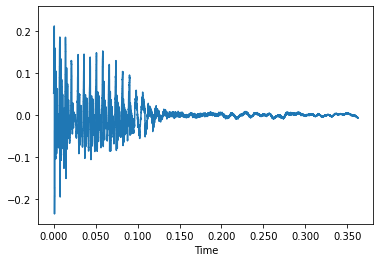

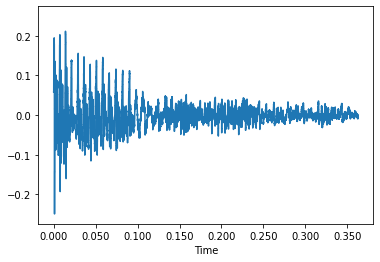

In [6]:
librosa.display.waveshow(np.squeeze(clean_train[3].numpy(),axis=-1))
plt.show()
librosa.display.waveshow(np.squeeze(noisy_train[3].numpy(),axis=-1))
plt.show()

In [7]:
clean_train.shape

TensorShape([67617, 8000, 1])

##  Testing data

In [8]:
TEST_CLEAN_PATH = os.path.join('data', 'clean_testset_wav')
TEST_NOISY_PATH = os.path.join('data', 'noisy_testset_wav')

test_clean_audio = glob.glob(TEST_CLEAN_PATH + '/*.wav')
test_noisy_audio = glob.glob(TEST_NOISY_PATH + '/*.wav')

In [9]:
test_clean_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(test_clean_audio[0]),desired_channels=1)
for i in tqdm(test_clean_audio[1:]):
    so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
    test_clean_sounds_list = tf.concat((test_clean_sounds_list,so),0)

test_noisy_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(test_noisy_audio[0]),desired_channels=1)
for i in tqdm(test_noisy_audio[1:]):
    so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
    test_noisy_sounds_list = tf.concat((test_noisy_sounds_list,so),0)

test_clean_sounds_list.shape, test_noisy_sounds_list.shape

  0%|          | 0/823 [00:00<?, ?it/s]

  0%|          | 0/823 [00:00<?, ?it/s]

(TensorShape([99457462, 1]), TensorShape([99457462, 1]))

In [10]:
test_clean_train, test_noisy_train = [],[]

for i in tqdm(range(0, test_clean_sounds_list.shape[0]-batching_size, batching_size)):
    test_clean_train.append(test_clean_sounds_list[i:i+batching_size])
    test_noisy_train.append(test_noisy_sounds_list[i:i+batching_size])

test_clean_train = tf.stack(test_clean_train)
test_noisy_train = tf.stack(test_noisy_train)

test_clean_train.shape, test_noisy_train.shape

  0%|          | 0/12432 [00:00<?, ?it/s]

(TensorShape([12432, 8000, 1]), TensorShape([12432, 8000, 1]))

# Get the spectrogram

In [11]:
def convert_spectrogram(wav1, wav2):
    wav1 = np.squeeze(wav1, axis=-1)
    wav2 = np.squeeze(wav2, axis=-1)
    
    spectrogram1 = tf.signal.stft(wav1, frame_length = 320, frame_step = 32)
    spectrogram1 = tf.abs(spectrogram1)
    spectrogram1 = tf.expand_dims(spectrogram1, axis = 2)
    
    spectrogram2 = tf.signal.stft(wav2, frame_length = 320, frame_step = 32)
    spectrogram2 = tf.abs(spectrogram2)
    spectrogram2 = tf.expand_dims(spectrogram2, axis = 2)
    return spectrogram1, spectrogram2

In [12]:
spectrogram1, spectrogram2 = convert_spectrogram(clean_train[7], noisy_train[7])

In [13]:
spectrogram1.shape

TensorShape([241, 257, 1])

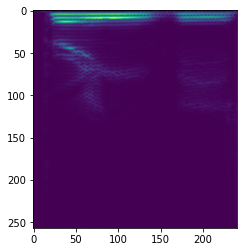

In [14]:
plt.figure()
plt.imshow(tf.transpose(spectrogram1)[0])
plt.show()

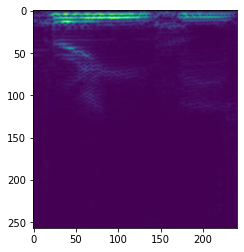

In [15]:
plt.figure()
plt.imshow(tf.transpose(spectrogram2)[0])
plt.show()

# Build the dataset

In [16]:
def convert_spectrogram_set(wav1, wav2):
    wav1 = tf.squeeze(wav1)
    spectrogram1 = tf.signal.stft(wav1, frame_length = 320, frame_step = 32)
    spectrogram1 = tf.abs(spectrogram1)
    spectrogram1 = tf.expand_dims(spectrogram1, axis = 2)
    
    wav2 = tf.squeeze(wav2)
    spectrogram2 = tf.signal.stft(wav2, frame_length = 320, frame_step = 32)
    spectrogram2 = tf.abs(spectrogram2)
    spectrogram2 = tf.expand_dims(spectrogram2, axis = 2)
    return spectrogram1, spectrogram2

In [17]:
def get_dataset(x_train, y_train):
    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    return dataset

In [18]:
train_dataset = get_dataset(noisy_train, clean_train)

In [19]:
train_dataset = train_dataset.map(convert_spectrogram_set)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size=100)
train_dataset = train_dataset.batch(64, drop_remainder=True)
train_dataset = train_dataset.prefetch(10)

In [20]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 241, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(64, 241, 257, 1), dtype=tf.float32, name=None))>

In [21]:
test_dataset = get_dataset(noisy_train, clean_train)

In [22]:
test_dataset = test_dataset.map(convert_spectrogram_set)
test_dataset = test_dataset.batch(64, drop_remainder=True)
test_dataset = test_dataset.prefetch(10)

In [23]:
test_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 241, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(64, 241, 257, 1), dtype=tf.float32, name=None))>

# Build the CNN model

In [24]:
def build_CNN_model(l2_strength):
    inputs = Input(shape=(241, 257, 1))
    x = inputs

    # -----
    x = tf.keras.layers.ZeroPadding2D(((4,4), (0,0)))(x)
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='valid', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    skip0 = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
                 kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(skip0)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # -----
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    skip1 = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
                 kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(skip1)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # ----
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # ----
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
             kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = x + skip1
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # ----
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
             kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = x + skip0
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # ----
    x = tf.keras.layers.SpatialDropout2D(0.2)(x)
    x = Conv2D(filters=1, kernel_size=[129,1], strides=[1, 1], padding='same')(x)

    model = Model(inputs=inputs, outputs=x)

    optimizer = tf.keras.optimizers.Adam(3e-4)

    model.compile(optimizer=optimizer, loss='mse', 
                metrics=[tf.keras.metrics.RootMeanSquaredError('rmse')])
    return model

In [29]:
model1 = build_CNN_model(l2_strength=0.0)
model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 241, 257, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 249, 257, 1)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_32 (Conv2D)             (None, 241, 257, 18  162         ['zero_padding2d_2[0][0]']       
                                )                                                           

                                                                                                  
 conv2d_41 (Conv2D)             (None, 241, 257, 18  1296        ['batch_normalization_38[0][0]'] 
                                )                                                                 
                                                                                                  
 activation_39 (Activation)     (None, 241, 257, 18  0           ['conv2d_41[0][0]']              
                                )                                                                 
                                                                                                  
 batch_normalization_39 (BatchN  (None, 241, 257, 18  72         ['activation_39[0][0]']          
 ormalization)                  )                                                                 
                                                                                                  
 conv2d_42

In [30]:
rec = model1.fit(train_dataset,
        steps_per_epoch=5,
#         validation_data = test_dataset,
        epochs= 3,
)

Epoch 1/3
5/5 [==============================] - 219s 42s/step - loss: 1.9879 - rmse: 1.4099
Epoch 2/3
5/5 [==============================] - 206s 41s/step - loss: 1.5666 - rmse: 1.2516
Epoch 3/3
5/5 [==============================] - 206s 41s/step - loss: 1.2455 - rmse: 1.1160


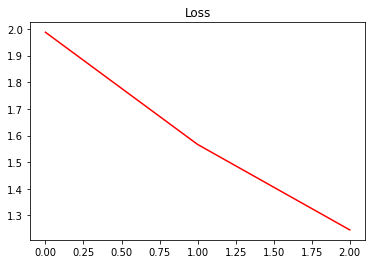

In [32]:
# plot the loss
plt.title('Loss')
plt.plot(rec.history['loss'], 'r')
plt.show()

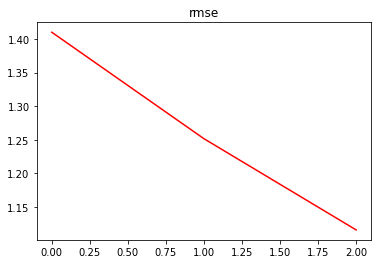

In [33]:
# plot the rmse
plt.title('rmse')
plt.plot(rec.history['rmse'], 'r')
plt.show()

# Test the model

In [34]:
X_test, y_test = list(test_dataset.as_numpy_iterator())[0]

In [36]:
h_test = model1.predict(X_test)

2/2 [==============================] - 9s 4s/step


In [40]:
h_test[0].shape

(241, 257, 1)

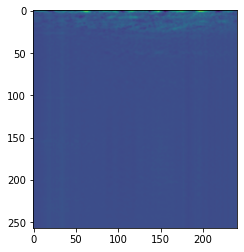

In [42]:
plt.figure()
plt.imshow(tf.transpose(h_test[0])[0])
plt.show()

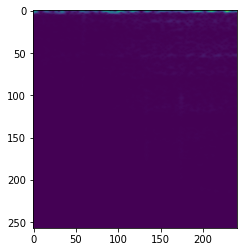

In [43]:
plt.figure()
plt.imshow(tf.transpose(y_test[0])[0])
plt.show()